In [1]:
# Using Ollama running on localhost
# Make sure Ollama is running with your preferred model:
# 
# 1. Start Ollama (if not already running):
#    ollama serve
# 
# 2. Pull a model (e.g., qwen3:latest):
#    ollama pull qwen3:latest
# 
# Then run this notebook!

In [2]:
# Memory-efficient analysis using Ollama local instance
import pandas as pd
import torch
import anthropic
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.stats import pearsonr
import requests
from googletrans import Translator
from datasets import load_dataset
import random
import time
from dotenv import load_dotenv
import os
import asyncio
import inspect
import nest_asyncio
import re
import gc

# Configuration
SYSTEM_PROMPT = '''You are an expert translator and language analyst. You will receive text in a JSON format that must be translated and explained. Your task is to:

1. Produce a complete, fluent translation of the entire input text.
2. Identify and explain:
   - The most challenging grammatical structures (e.g. verb tenses, clause structures, agreement, word order, subordination, complex sentences), and
   - The most challenging or hard-to-understand phrases/expressions (e.g. idioms, collocations, ambiguous phrases, fixed expressions).

The input JSON format is:
{"input_text": "<text_here>"}

You must respond with a single JSON object in the following format:
{
  "translated_text": "<translated_text>",
  "explainations_list": [
    ["<challenging_part_1>", "<explanation_1>"],
    ["<challenging_part_2>", "<explanation_2>"]
  ]
}

Where:
- "translated_text" is the complete, fluent translation of the entire "input_text".
- "explainations_list" is a list of tuples (2-element arrays):
  - The first element is a challenging part taken directly from "input_text". This can be either:
    - a grammatical structure (clause, verb group, sentence fragment, etc.), or
    - a phrase/expression that is hard to understand or translate literally.
  - The second element is a clear explanation (in the target language) that:
    - for grammatical structures: describes the relevant grammar (e.g. tense, aspect, mood, syntax, agreement, clause type) and how it affects meaning;
    - for phrases/expressions: explains the intended meaning, why it is challenging (idiomatic, ambiguous, non-literal, etc.), and how that meaning is captured in the translation.

Important rules:
- Cover both types of difficulties: grammar AND challenging phrases/expressions whenever they are present.
- Focus explanations on what makes each selected part non-trivial to understand or translate.
- Respond with only the valid JSON and only the valid JSON.
- Do not output any other strings, comments, or messages outside the JSON.
- Ensure the JSON is syntactically valid (double quotes for all keys and string values, no trailing commas).'''

# Memory control options
SKIP_QWEN = os.getenv("SKIP_QWEN", "false").lower() == "true"  # Set SKIP_QWEN=true in .env to skip Qwen
FORCE_CPU = os.getenv("FORCE_CPU", "false").lower() == "true"  # Set FORCE_CPU=true to force CPU usage

print(f"Memory control: SKIP_QWEN={SKIP_QWEN}, FORCE_CPU={FORCE_CPU}")

# Load environment variables
load_dotenv()

# Get API keys and Ollama configuration from environment
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
OLLAMA_API_BASE = os.getenv("OLLAMA_API_BASE", "http://localhost:10000")  # Default Ollama endpoint
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "qwen3:latest")  # Default model

# Validate API keys
if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found in .env file")

print(f"Ollama API endpoint: {OLLAMA_API_BASE}")
print(f"Ollama model: {OLLAMA_MODEL}")

# Load dataset from Hugging Face Datasets (wmt/wmt19 zh-en)
SAMPLE_SIZE_ENV = os.getenv("SAMPLE_SIZE")
try:
    SAMPLE_SIZE = int(SAMPLE_SIZE_ENV) if SAMPLE_SIZE_ENV is not None else 5  # Reduced default
except ValueError:
    print(f"Invalid SAMPLE_SIZE in .env ('{SAMPLE_SIZE_ENV}'), falling back to 5")
    SAMPLE_SIZE = 5
if SAMPLE_SIZE <= 0:
    raise ValueError("SAMPLE_SIZE must be a positive integer")
print(f"Loading WMT19 zh-en dataset from Hugging Face (sample size={SAMPLE_SIZE})...")

# Use the Hugging Face dataset id and config for Chinese-English
try:
    ds = load_dataset('wmt/wmt19', 'zh-en', split='validation')
    print(f"Successfully loaded WMT19 dataset with {len(ds)} examples")
    ds = ds.shuffle(seed=42)
    subset = ds.select(range(min(SAMPLE_SIZE, len(ds))))
except Exception as e:
    raise RuntimeError(f"Failed to load wmt/wmt19 zh-en from Hugging Face datasets: {e}")

# Initialize Claude client (lightweight)
claude_client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

# Initialize sentence transformer (moderate memory usage)
print("Loading sentence transformer for similarity comparison...")
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# Google Translate function (robust to sync/async) - Fixed version
def google_translate(text, from_lang='zh', to_lang='en'):
    try:
        dest = to_lang
        src = from_lang
        if from_lang == 'zh':
            src = 'zh-cn'
        if to_lang == 'zh':
            dest = 'zh-cn'
        translator = Translator()
        result = translator.translate(text, src=src, dest=dest)

        # Check if result is a coroutine first
        if inspect.iscoroutine(result):
            try:
                # Try to get existing event loop
                loop = asyncio.get_event_loop()
                if loop.is_running():
                    # We're in Jupyter/async context, use nest_asyncio
                    nest_asyncio.apply()
                result = loop.run_until_complete(result)
            except RuntimeError:
                # No event loop, create one
                result = asyncio.run(result)
        
        # Now result should be the actual translation object
        if hasattr(result, 'text'):
            return result.text
        else:
            # Fallback: assume result is already the text
            return str(result)
    except Exception as e:
        print(f"Google translate error: {e}")
        return None

# Helper to strip Qwen 'thinking' traces
def _clean_thinking(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r"<think>.*?</think>", "", text, flags=re.S)
    text = re.sub(r"<think>.*$", "", text, flags=re.S)
    return text.strip()

# Connect to Ollama local instance
ollama_connected = None

def load_qwen_if_needed():
    global ollama_connected
    if SKIP_QWEN:
        print("Skipping Qwen model (SKIP_QWEN=true)")
        return False
    
    if ollama_connected is None:
        print(f"Connecting to Ollama at {OLLAMA_API_BASE}...")
        try:
            # Test connection by listing models
            response = requests.get(f"{OLLAMA_API_BASE}/api/tags")
            if response.status_code == 200:
                models = response.json().get('models', [])
                model_names = [m['name'] for m in models]
                print(f"✓ Connected to Ollama")
                print(f"Available models: {model_names}")
                
                # Check if our model is available
                if OLLAMA_MODEL not in model_names:
                    print(f"⚠ Model '{OLLAMA_MODEL}' not found. You may need to: ollama pull {OLLAMA_MODEL}")
                
                ollama_connected = True
                return True
            else:
                print(f"✗ Failed to connect to Ollama: HTTP {response.status_code}")
                ollama_connected = False
                return False
        except Exception as e:
            print(f"Failed to connect to Ollama: {e}")
            print("Make sure Ollama is running: ollama serve")
            print("Continuing without Qwen...")
            ollama_connected = False
            return False
    return ollama_connected

def prompt_qwen(text):
    if not load_qwen_if_needed():
        return '{"translated_text": "Qwen unavailable", "explanations_list": []}'
    
    input_json = json.dumps({"input_text": text})
    
    # Construct prompt with system and user messages
    prompt = f"System: {SYSTEM_PROMPT}\n\nUser: {input_json}\n\nAssistant:"
    
    print(f"  [Debug] Calling Ollama")
    start_time = time.time()
    
    try:
        # Call Ollama API
        response = requests.post(
            f"{OLLAMA_API_BASE}/api/generate",
            json={
            "model": OLLAMA_MODEL,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.7,
                "top_p": 0.9,
                "num_predict": 8192,
                "num_ctx": 81920,  # Increase context length to 81920 tokens
                "enable_thinking": True,  # Enable thinking mode
            }
            },
            timeout=120  # 2 minute timeout
        )
        
        elapsed = time.time() - start_time
        print(f"  [Debug] Generation took {elapsed:.2f}s")
        
        if response.status_code == 200:
            result = response.json()
            # Check both 'response' and 'thinking' fields
            # Some Qwen models put everything in 'thinking'
            response_text = result.get('response', '').strip()
            thinking_text = result.get('thinking', '').strip()
            
            # If response is empty but thinking has content, use thinking
            if not response_text and thinking_text:
                print(f"  [Debug] Using thinking field as response is empty")
                response_text = thinking_text
            
            return response_text
        else:
            print(f"  [Error] Ollama request failed: HTTP {response.status_code}")
            return '{"translated_text": "Qwen error", "explanations_list": []}'
        
    except Exception as e:
        print(f"  [Error] Ollama request failed: {e}")
        return '{"translated_text": "Qwen error", "explanations_list": []}'

def prompt_claude(text):
    input_json = json.dumps({"input_text": text})
    message = claude_client.messages.create(
        model="claude-opus-4-20250514",
        max_tokens=1024,
        system=SYSTEM_PROMPT,
        messages=[{"role": "user", "content": input_json}]
    )
    return message.content[0].text

def cleanup_memory():
    """Clean up GPU memory between operations"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def check_gpu_usage():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            allocated = torch.cuda.memory_allocated(i) / 1e9
            reserved = torch.cuda.memory_reserved(i) / 1e9
            print(f"  GPU {i}: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")

print("Setup complete! Models will be loaded on-demand to save memory.")

/home/womywomwoo/Source/scheme-cu-silvia/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Memory control: SKIP_QWEN=False, FORCE_CPU=False
Ollama API endpoint: http://localhost:10000
Ollama model: qwen3:latest
Loading WMT19 zh-en dataset from Hugging Face (sample size=1)...
Successfully loaded WMT19 dataset with 3981 examples
Loading sentence transformer for similarity comparison...
Setup complete! Models will be loaded on-demand to save memory.


In [3]:
# Memory-efficient processing loop
results = []

print(f"\nStarting translation comparison analysis for {SAMPLE_SIZE} examples...")
print("=" * 60)

for idx, example in enumerate(subset):
    try:
        translation = example['translation']
        text = translation.get('zh') if isinstance(translation, dict) else ''
        reference_translation = translation.get('en') if isinstance(translation, dict) else ''
    except Exception:
        text = ''
        reference_translation = ''

    if not text:
        continue

    print(f"\nProcessing [{idx+1}/{SAMPLE_SIZE}]: {text[:60]}...")

    # Get Claude response first (lighter)
    claude_response = prompt_claude(text)
    print(f"✓ Claude: {claude_response[:80]}...")
    
    # Clean up memory
    cleanup_memory()

    # Get Qwen response (heavier, optional)
    qwen_raw = prompt_qwen(text)
    qwen_response = _clean_thinking(qwen_raw)
    print(f"✓ Qwen: {qwen_response[:80]}...")
    
    # Clean up memory after Qwen 
    cleanup_memory()

    # Get Google translation (lightweight)
    google_translation = google_translate(text, from_lang='zh', to_lang='en')
    print(f"✓ Google: {google_translation}")
    
    # Parse JSON responses
    try:
        qwen_json = json.loads(qwen_response)
        qwen_translation = qwen_json.get('translated_text', '')
    except Exception:
        print(f"parse failed for {qwen_response}")
        qwen_translation = ''

    try:
        claude_json = json.loads(claude_response)
        claude_translation = claude_json.get('translated_text', '')
    except Exception:
        claude_translation = ''

    # Calculate semantic similarities
    try:
        embeddings = similarity_model.encode([qwen_response, claude_response])
        cosine_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    except Exception:
        cosine_sim = 0

    # Translation similarity (Qwen vs Claude)
    trans_sim = 0
    if qwen_translation and claude_translation:
        try:
            trans_embeddings = similarity_model.encode([qwen_translation, claude_translation])
            trans_sim = cosine_similarity([trans_embeddings[0]], [trans_embeddings[1]])[0][0]
        except Exception:
            trans_sim = 0

    # Google vs other translations
    google_qwen_sim = 0
    google_claude_sim = 0
    if google_translation:
        if qwen_translation:
            try:
                google_qwen_embeddings = similarity_model.encode([google_translation, qwen_translation])
                google_qwen_sim = cosine_similarity([google_qwen_embeddings[0]], [google_qwen_embeddings[1]])[0][0]
            except Exception:
                pass
        
        if claude_translation:
            try:
                google_claude_embeddings = similarity_model.encode([google_translation, claude_translation])
                google_claude_sim = cosine_similarity([google_claude_embeddings[0]], [google_claude_embeddings[1]])[0][0]
            except Exception:
                pass

    # Reference similarities
    ref_qwen_sim = ref_claude_sim = google_ref_sim = 0
    if reference_translation:
        if qwen_translation:
            try:
                ref_qwen_embeddings = similarity_model.encode([qwen_translation, reference_translation])
                ref_qwen_sim = cosine_similarity([ref_qwen_embeddings[0]], [ref_qwen_embeddings[1]])[0][0]
            except Exception:
                pass
        
        if claude_translation:
            try:
                ref_claude_embeddings = similarity_model.encode([claude_translation, reference_translation])
                ref_claude_sim = cosine_similarity([ref_claude_embeddings[0]], [ref_claude_embeddings[1]])[0][0]
            except Exception:
                pass
        
        if google_translation:
            try:
                google_ref_embeddings = similarity_model.encode([google_translation, reference_translation])
                google_ref_sim = cosine_similarity([google_ref_embeddings[0]], [google_ref_embeddings[1]])[0][0]
            except Exception:
                pass

    results.append({
        'input_text': text,
        'reference_translation': reference_translation,
        'qwen_response': qwen_response,
        'claude_response': claude_response,
        'qwen_translation': qwen_translation,
        'claude_translation': claude_translation,
        'google_translation': google_translation,
        'full_response_similarity': cosine_sim,
        'translation_similarity': trans_sim,
        'google_qwen_similarity': google_qwen_sim,
        'google_claude_similarity': google_claude_sim,
        'ref_qwen_similarity': ref_qwen_sim,
        'ref_claude_similarity': ref_claude_sim,
        'google_ref_similarity': google_ref_sim
    })

    # Rate limiting and memory cleanup
    time.sleep(1)
    cleanup_memory()

print(f"\n✓ Completed processing {len(results)} examples")
print("=" * 60)


Starting translation comparison analysis for 1 examples...

Processing [1/1]: 他说，根据安全摄像头，确认莱塞姆和沃伦当时在大楼里。...
✓ Claude: {
  "translated_text": "He said that based on security camera footage, it was co...
Connecting to Ollama at http://localhost:10000...
✓ Connected to Ollama
Available models: ['qwen3:latest', 'gemma3:latest', 'gemma3:27b-it-fp16', 'deepseek-r1:14b', 'mxbai-embed-large:latest', 'deepseek-coder-v2:latest', 'deepseek-r1:1.5b']
  [Debug] Calling Ollama
  [Debug] Generation took 98.77s
✓ Qwen: {
  "translated_text": "He said that according to the head of security, Blue Rid...
✓ Google: He said security cameras confirmed Latham and Warren were in the building at the time.

✓ Completed processing 1 examples


In [4]:
print(results[0]["input_text"])
print("claude_translation", results[0]["claude_translation"])
print("reference_translation", results[0]["reference_translation"])
print("qwen_translation", results[0]["qwen_translation"])
print("google_translation", results[0]["google_translation"])

他说，根据安全摄像头，确认莱塞姆和沃伦当时在大楼里。
claude_translation He said that based on security camera footage, it was confirmed that Lesem and Warren were in the building at that time.
reference_translation Lathem and Warren were confirmed to be at the building by security cameras, he said.
qwen_translation He said that according to the head of security, Blue Ridge and Paxton were confirmed to be in the hall at that time.
google_translation He said security cameras confirmed Latham and Warren were in the building at the time.


/tmp/ipykernel_215567/2026041076.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=['Qwen vs\nClaude', 'Qwen vs\nGoogle', 'Claude vs\nGoogle', 'Qwen vs\nRef', 'Claude vs\nRef', 'Google vs\nRef'])


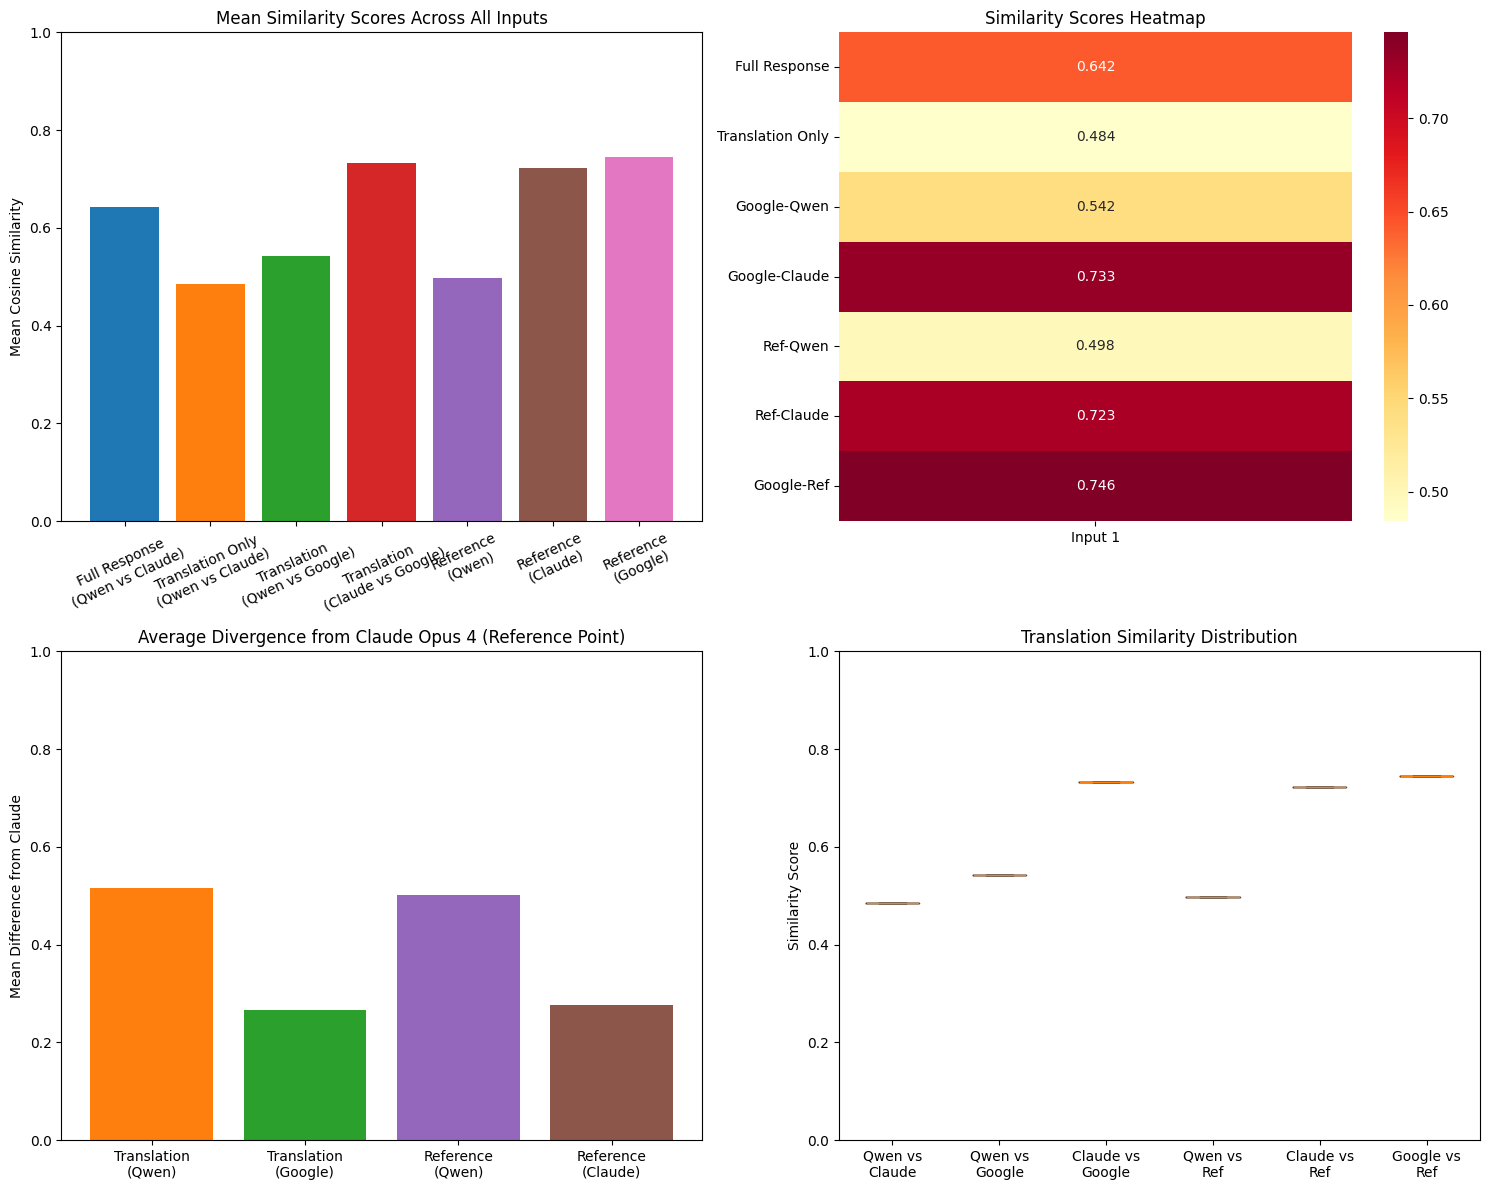


📊 Visualization saved as 'model_comparison_analysis.png'


In [5]:
# Create results dataframe and visualizations
results_df = pd.DataFrame(results)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean similarity scores
similarity_means = {
    'Full Response\n(Qwen vs Claude)': results_df['full_response_similarity'].mean(),
    'Translation Only\n(Qwen vs Claude)': results_df['translation_similarity'].mean(),
    'Translation\n(Qwen vs Google)': results_df['google_qwen_similarity'].mean(),
    'Translation\n(Claude vs Google)': results_df['google_claude_similarity'].mean(),
    'Reference\n(Qwen)': results_df['ref_qwen_similarity'].mean(),
    'Reference\n(Claude)': results_df['ref_claude_similarity'].mean(),
    'Reference\n(Google)': results_df['google_ref_similarity'].mean()
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
axes[0, 0].bar(similarity_means.keys(), similarity_means.values(), color=colors[:len(similarity_means)])
axes[0, 0].set_ylabel('Mean Cosine Similarity')
axes[0, 0].set_title('Mean Similarity Scores Across All Inputs')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=25)

# 2. Per-input similarity heatmap
similarity_matrix = results_df[[
    'full_response_similarity', 'translation_similarity', 'google_qwen_similarity',
    'google_claude_similarity', 'ref_qwen_similarity', 'ref_claude_similarity', 'google_ref_similarity'
]].T
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 1],
            xticklabels=[f"Input {i+1}" for i in range(len(results_df))],
            yticklabels=['Full Response', 'Translation Only', 'Google-Qwen', 'Google-Claude', 'Ref-Qwen', 'Ref-Claude', 'Google-Ref'])
axes[0, 1].set_title('Similarity Scores Heatmap')

# 3. Difference from Claude (reference point)
difference_data = {
    'Translation\n(Qwen)': 1 - results_df['translation_similarity'].mean(),
    'Translation\n(Google)': 1 - results_df['google_claude_similarity'].mean(),
    'Reference\n(Qwen)': 1 - results_df['ref_qwen_similarity'].mean(),
    'Reference\n(Claude)': 1 - results_df['ref_claude_similarity'].mean()
}

axes[1, 0].bar(difference_data.keys(), difference_data.values(), color=['#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'])
axes[1, 0].set_ylabel('Mean Difference from Claude')
axes[1, 0].set_title('Average Divergence from Claude Opus 4 (Reference Point)')
axes[1, 0].set_ylim([0, 1])

# 4. Box plot of similarities
box_data = [
    results_df['translation_similarity'],
    results_df['google_qwen_similarity'],
    results_df['google_claude_similarity'],
    results_df['ref_qwen_similarity'],
    results_df['ref_claude_similarity'],
    results_df['google_ref_similarity']
]

axes[1, 1].boxplot(box_data, labels=['Qwen vs\nClaude', 'Qwen vs\nGoogle', 'Claude vs\nGoogle', 'Qwen vs\nRef', 'Claude vs\nRef', 'Google vs\nRef'])
axes[1, 1].set_ylabel('Similarity Score')
axes[1, 1].set_title('Translation Similarity Distribution')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("📊 Visualization saved as 'model_comparison_analysis.png'")
print("="*60)

In [6]:
# Summary statistics
print("\n" + "="*60)
print("📈 SUMMARY STATISTICS")
print("="*60)
print(f"\nMean Full Response Similarity (Qwen vs Claude): {results_df['full_response_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Qwen vs Claude): {results_df['translation_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Qwen vs Google): {results_df['google_qwen_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Claude vs Google): {results_df['google_claude_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Qwen vs Ref): {results_df['ref_qwen_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Claude vs Ref): {results_df['ref_claude_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Google vs Ref): {results_df['google_ref_similarity'].mean():.4f}")

print(f"\n🔍 DIVERGENCE METRICS")
print(f"Qwen divergence from Claude (mean): {(1 - results_df['translation_similarity'].mean()):.4f}")
print(f"Google divergence from Claude (mean): {(1 - results_df['google_claude_similarity'].mean()):.4f}")
print(f"Qwen divergence from Reference (mean): {(1 - results_df['ref_qwen_similarity'].mean()):.4f}")
print(f"Claude divergence from Reference (mean): {(1 - results_df['ref_claude_similarity'].mean()):.4f}")
print(f"Google divergence from Reference (mean): {(1 - results_df['google_ref_similarity'].mean()):.4f}")

# Display detailed results
print("\n" + "="*60)
print("📋 DETAILED RESULTS TABLE")
print("="*60)
print(results_df[['input_text', 'qwen_translation', 'claude_translation', 'google_translation', 
                  'translation_similarity', 'ref_qwen_similarity', 'ref_claude_similarity']].to_string())

print("\n" + "="*60)
print("✅ Analysis complete!")
print("="*60)


📈 SUMMARY STATISTICS

Mean Full Response Similarity (Qwen vs Claude): 0.6417
Mean Translation Similarity (Qwen vs Claude): 0.4844
Mean Translation Similarity (Qwen vs Google): 0.5424
Mean Translation Similarity (Claude vs Google): 0.7335
Mean Reference Similarity (Qwen vs Ref): 0.4976
Mean Reference Similarity (Claude vs Ref): 0.7234
Mean Reference Similarity (Google vs Ref): 0.7459

🔍 DIVERGENCE METRICS
Qwen divergence from Claude (mean): 0.5156
Google divergence from Claude (mean): 0.2665
Qwen divergence from Reference (mean): 0.5024
Claude divergence from Reference (mean): 0.2766
Google divergence from Reference (mean): 0.2541

📋 DETAILED RESULTS TABLE
                   input_text                                                                                                      qwen_translation                                                                                                        claude_translation                                                                  


🔬 SEMANTIC COMPARISON ANALYSIS: Models vs Reference Translations

📊 Computing semantic embeddings for all translations...
✓ Generated semantic embeddings for 1 examples

📈 Computing pairwise semantic similarities...
✓ Computed pairwise similarities for all 1 examples

📊 Creating semantic similarity visualizations...


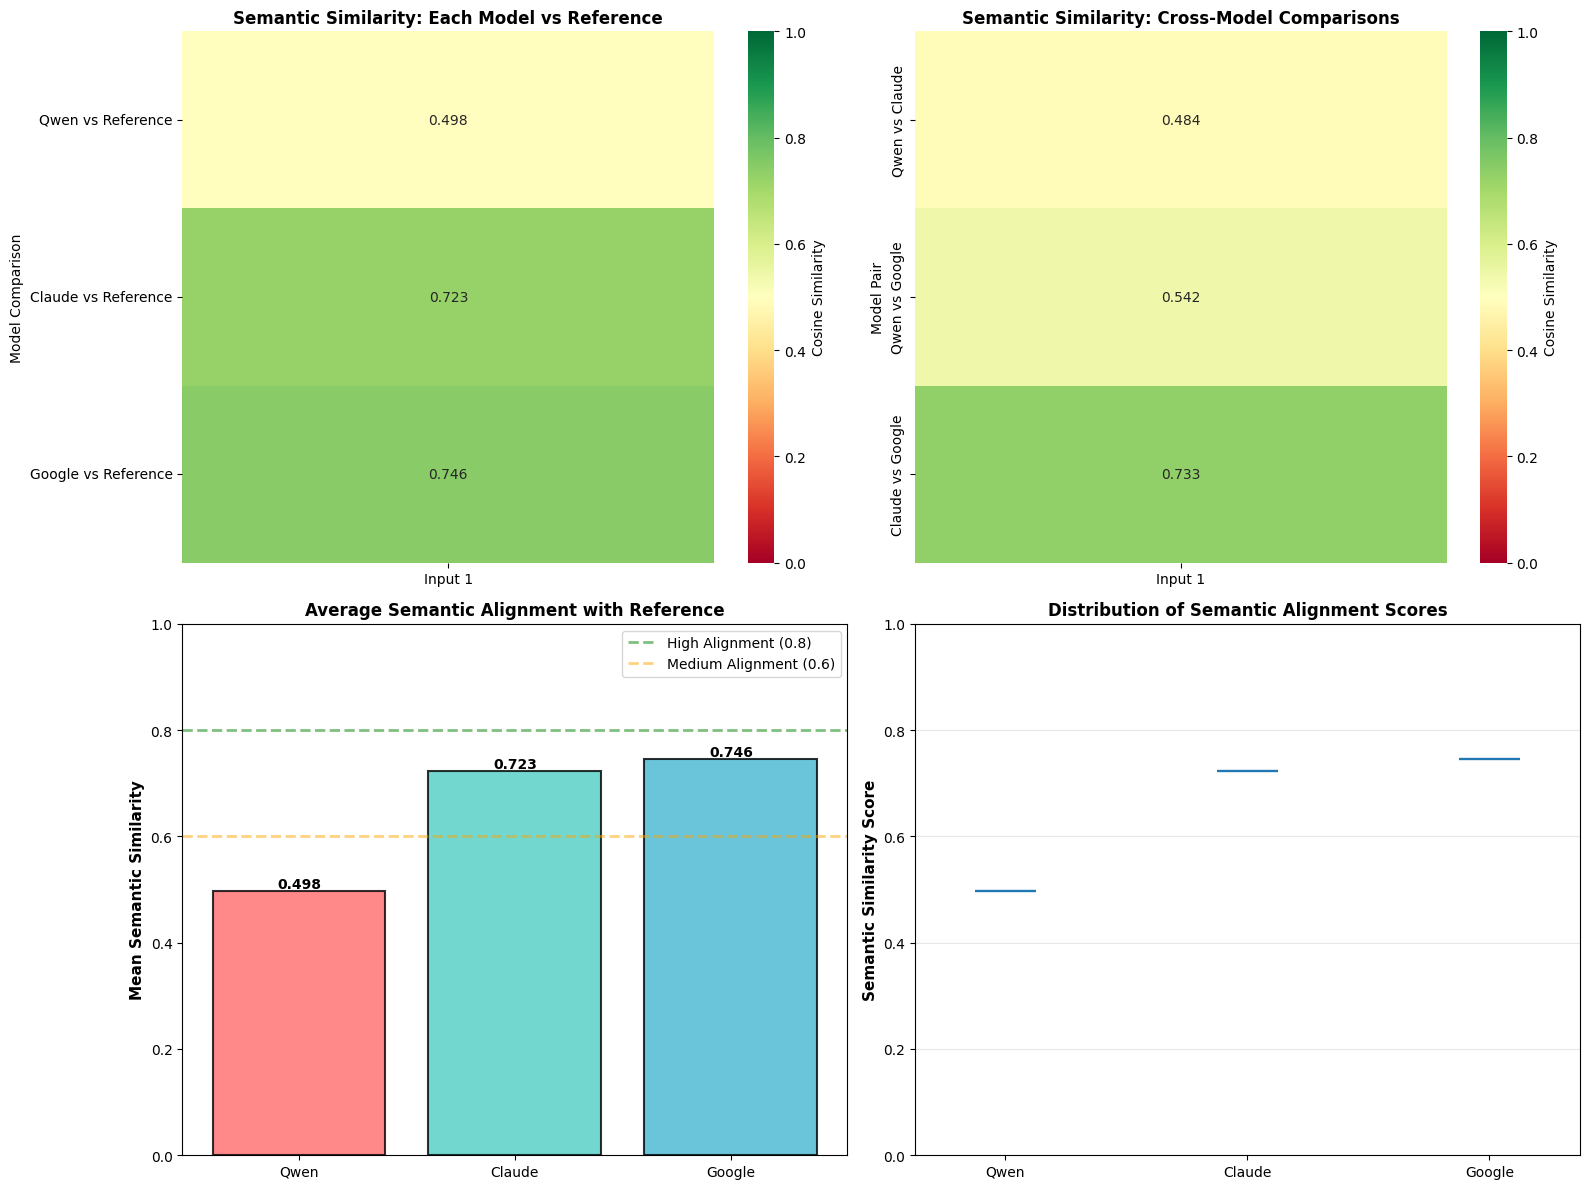

✓ Semantic comparison visualizations saved as 'semantic_comparison_analysis.png'

📋 SEMANTIC SIMILARITY STATISTICS

 Model  Mean Similarity to Reference  Median Similarity  Std Dev  Min Similarity  Max Similarity
  Qwen                      0.497572           0.497572      NaN        0.497572        0.497572
Claude                      0.723390           0.723390      NaN        0.723390        0.723390
Google                      0.745893           0.745893      NaN        0.745893        0.745893

🔀 CROSS-MODEL SEMANTIC CONSISTENCY

      Comparison  Mean Similarity  Consistency (Std Dev)
  Qwen vs Claude         0.484377                    NaN
  Qwen vs Google         0.542431                    NaN
Claude vs Google         0.733497                    NaN

📊 PER-EXAMPLE SEMANTIC ALIGNMENT SCORES

  Input  Qwen vs Reference  Claude vs Reference  Google vs Reference  Qwen vs Claude  Qwen vs Google  Claude vs Google
Input 1           0.497572              0.72339             0.745893  

In [7]:
# Semantic Comparison Analysis: Models vs Reference
print("\n" + "="*70)
print("🔬 SEMANTIC COMPARISON ANALYSIS: Models vs Reference Translations")
print("="*70)

# 1. Semantic Embeddings for all translations and reference
print("\n📊 Computing semantic embeddings for all translations...")
semantic_data = []

for idx, row in results_df.iterrows():
    if not row['reference_translation'] or not row['qwen_translation']:
        continue
    
    try:
        # Get embeddings for all translations and reference
        texts_to_embed = [
            row['qwen_translation'],
            row['claude_translation'],
            row['google_translation'],
            row['reference_translation']
        ]
        
        embeddings = similarity_model.encode(texts_to_embed)
        
        semantic_data.append({
            'input_idx': idx,
            'input_text': row['input_text'][:50] + '...',
            'qwen_embed': embeddings[0],
            'claude_embed': embeddings[1],
            'google_embed': embeddings[2],
            'ref_embed': embeddings[3],
            'qwen_trans': row['qwen_translation'],
            'claude_trans': row['claude_translation'],
            'google_trans': row['google_translation'],
            'ref_trans': row['reference_translation'],
        })
    except Exception as e:
        print(f"  ⚠ Error processing row {idx}: {e}")
        continue

print(f"✓ Generated semantic embeddings for {len(semantic_data)} examples")

# 2. Detailed pairwise semantic similarity matrix
print("\n📈 Computing pairwise semantic similarities...")
pairwise_comparisons = []

for data in semantic_data:
    idx = data['input_idx']
    
    # Compute all pairwise similarities
    pairs = {
        'Qwen vs Reference': cosine_similarity([data['qwen_embed']], [data['ref_embed']])[0][0],
        'Claude vs Reference': cosine_similarity([data['claude_embed']], [data['ref_embed']])[0][0],
        'Google vs Reference': cosine_similarity([data['google_embed']], [data['ref_embed']])[0][0],
        'Qwen vs Claude': cosine_similarity([data['qwen_embed']], [data['claude_embed']])[0][0],
        'Qwen vs Google': cosine_similarity([data['qwen_embed']], [data['google_embed']])[0][0],
        'Claude vs Google': cosine_similarity([data['claude_embed']], [data['google_embed']])[0][0],
    }
    
    pairwise_comparisons.append({
        'input_idx': idx,
        **pairs
    })

pairwise_df = pd.DataFrame(pairwise_comparisons)
print(f"✓ Computed pairwise similarities for all {len(pairwise_df)} examples")

# 3. Visualization 1: Semantic Similarity Heatmap (Models vs Reference)
print("\n📊 Creating semantic similarity visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: Pairwise semantic similarities
models_ref_similarity = pairwise_df[[
    'Qwen vs Reference',
    'Claude vs Reference',
    'Google vs Reference'
]].T

sns.heatmap(models_ref_similarity, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0],
            xticklabels=[f"Input {i+1}" for i in range(len(pairwise_df))],
            vmin=0, vmax=1, cbar_kws={'label': 'Cosine Similarity'})
axes[0, 0].set_title('Semantic Similarity: Each Model vs Reference', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Model Comparison')

# Heatmap 2: Cross-model comparisons
model_cross_similarity = pairwise_df[[
    'Qwen vs Claude',
    'Qwen vs Google',
    'Claude vs Google'
]].T

sns.heatmap(model_cross_similarity, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 1],
            xticklabels=[f"Input {i+1}" for i in range(len(pairwise_df))],
            vmin=0, vmax=1, cbar_kws={'label': 'Cosine Similarity'})
axes[0, 1].set_title('Semantic Similarity: Cross-Model Comparisons', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Model Pair')

# Chart 3: Mean semantic similarity scores (Models vs Reference)
mean_vs_ref = {
    'Qwen': pairwise_df['Qwen vs Reference'].mean(),
    'Claude': pairwise_df['Claude vs Reference'].mean(),
    'Google': pairwise_df['Google vs Reference'].mean(),
}

bars = axes[1, 0].bar(mean_vs_ref.keys(), mean_vs_ref.values(), 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Mean Semantic Similarity', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Semantic Alignment with Reference', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='High Alignment (0.8)')
axes[1, 0].axhline(y=0.6, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Medium Alignment (0.6)')
axes[1, 0].legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Chart 4: Distribution comparison (violin plot)
data_for_violin = [
    pairwise_df['Qwen vs Reference'].values,
    pairwise_df['Claude vs Reference'].values,
    pairwise_df['Google vs Reference'].values,
]

parts = axes[1, 1].violinplot(data_for_violin, positions=[1, 2, 3], 
                              showmeans=True, showmedians=True)
axes[1, 1].set_xticks([1, 2, 3])
axes[1, 1].set_xticklabels(['Qwen', 'Claude', 'Google'])
axes[1, 1].set_ylabel('Semantic Similarity Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Semantic Alignment Scores', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('semantic_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Semantic comparison visualizations saved as 'semantic_comparison_analysis.png'")

# 4. Detailed statistics table
print("\n" + "="*70)
print("📋 SEMANTIC SIMILARITY STATISTICS")
print("="*70)

stats_summary = pd.DataFrame({
    'Model': ['Qwen', 'Claude', 'Google'],
    'Mean Similarity to Reference': [
        pairwise_df['Qwen vs Reference'].mean(),
        pairwise_df['Claude vs Reference'].mean(),
        pairwise_df['Google vs Reference'].mean(),
    ],
    'Median Similarity': [
        pairwise_df['Qwen vs Reference'].median(),
        pairwise_df['Claude vs Reference'].median(),
        pairwise_df['Google vs Reference'].median(),
    ],
    'Std Dev': [
        pairwise_df['Qwen vs Reference'].std(),
        pairwise_df['Claude vs Reference'].std(),
        pairwise_df['Google vs Reference'].std(),
    ],
    'Min Similarity': [
        pairwise_df['Qwen vs Reference'].min(),
        pairwise_df['Claude vs Reference'].min(),
        pairwise_df['Google vs Reference'].min(),
    ],
    'Max Similarity': [
        pairwise_df['Qwen vs Reference'].max(),
        pairwise_df['Claude vs Reference'].max(),
        pairwise_df['Google vs Reference'].max(),
    ],
})

print("\n" + stats_summary.to_string(index=False))

# 5. Cross-model semantic consistency
print("\n" + "="*70)
print("🔀 CROSS-MODEL SEMANTIC CONSISTENCY")
print("="*70)

cross_model_stats = pd.DataFrame({
    'Comparison': ['Qwen vs Claude', 'Qwen vs Google', 'Claude vs Google'],
    'Mean Similarity': [
        pairwise_df['Qwen vs Claude'].mean(),
        pairwise_df['Qwen vs Google'].mean(),
        pairwise_df['Claude vs Google'].mean(),
    ],
    'Consistency (Std Dev)': [
        pairwise_df['Qwen vs Claude'].std(),
        pairwise_df['Qwen vs Google'].std(),
        pairwise_df['Claude vs Google'].std(),
    ],
})

print("\n" + cross_model_stats.to_string(index=False))

# 6. Per-example detailed analysis
print("\n" + "="*70)
print("📊 PER-EXAMPLE SEMANTIC ALIGNMENT SCORES")
print("="*70)

detailed_alignment = pairwise_df.copy()
detailed_alignment['Input'] = detailed_alignment.apply(
    lambda row: f"Input {int(row['input_idx']) + 1}", axis=1
)

# Reorder columns for better readability
alignment_display = detailed_alignment[[
    'Input',
    'Qwen vs Reference',
    'Claude vs Reference',
    'Google vs Reference',
    'Qwen vs Claude',
    'Qwen vs Google',
    'Claude vs Google'
]]

print("\n" + alignment_display.to_string(index=False))

# 7. Rankings and insights
print("\n" + "="*70)
print("🏆 MODEL PERFORMANCE RANKINGS (Per Input)")
print("="*70)

rankings = []
for idx, row in pairwise_df.iterrows():
    ref_sims = {
        'Qwen': row['Qwen vs Reference'],
        'Claude': row['Claude vs Reference'],
        'Google': row['Google vs Reference'],
    }
    
    ranked = sorted(ref_sims.items(), key=lambda x: x[1], reverse=True)
    rankings.append({
        'Input': f"Input {int(row['input_idx']) + 1}",
        '1st': f"{ranked[0][0]} ({ranked[0][1]:.3f})",
        '2nd': f"{ranked[1][0]} ({ranked[1][1]:.3f})",
        '3rd': f"{ranked[2][0]} ({ranked[2][1]:.3f})",
    })

rankings_df = pd.DataFrame(rankings)
print("\n" + rankings_df.to_string(index=False))

# 8. Overall winner determination
print("\n" + "="*70)
print("🎯 OVERALL SEMANTIC ALIGNMENT WINNER")
print("="*70)

winner_scores = {
    'Qwen': (pairwise_df['Qwen vs Reference'] > pairwise_df['Claude vs Reference']).sum() +
            (pairwise_df['Qwen vs Reference'] > pairwise_df['Google vs Reference']).sum(),
    'Claude': (pairwise_df['Claude vs Reference'] > pairwise_df['Qwen vs Reference']).sum() +
              (pairwise_df['Claude vs Reference'] > pairwise_df['Google vs Reference']).sum(),
    'Google': (pairwise_df['Google vs Reference'] > pairwise_df['Qwen vs Reference']).sum() +
              (pairwise_df['Google vs Reference'] > pairwise_df['Claude vs Reference']).sum(),
}

sorted_winners = sorted(winner_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\n🥇 {sorted_winners[0][0]}: {sorted_winners[0][1]} wins")
print(f"🥈 {sorted_winners[1][0]}: {sorted_winners[1][1]} wins")
print(f"🥉 {sorted_winners[2][0]}: {sorted_winners[2][1]} wins")

print("\n" + "="*70)
print("✅ Semantic comparison analysis complete!")
print("="*70)